In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [68]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import PIL
from PIL import Image
# loading in and transforming data
import os
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

%matplotlib inline

In [69]:
base_path = "../input/gan-getting-started/"
monet_path = base_path + 'monet_jpg'
monet_folder = os.listdir(monet_path)
photo_path = base_path + 'photo_jpg'
photo_folder = os.listdir(photo_path)
print(len(monet_folder),len(photo_folder))

300 7038


In [70]:
from glob import glob
monet_Patches = glob('../input/gan-getting-started/monet_jpg/*.jpg', recursive=True)
photo_Patches = glob('../input/gan-getting-started/photo_jpg/*.jpg', recursive=True)
print(len(monet_Patches),len(photo_Patches)) # total no. of images

300 7038


In [71]:
monet_df = pd.DataFrame()
monet_df["images"] = monet_Patches
monet_df = monet_df.reset_index(drop=True)
monet_df.head()

,images
0,../input/gan-getting-started/monet_jpg/8314acf...
1,../input/gan-getting-started/monet_jpg/1994b8d...
2,../input/gan-getting-started/monet_jpg/0bd913d...
3,../input/gan-getting-started/monet_jpg/7239ba0...
4,../input/gan-getting-started/monet_jpg/4ad8b36...


In [72]:
photo_df = pd.DataFrame()
photo_df["images"] = photo_Patches
photo_df = photo_df.reset_index(drop=True)
photo_df.head()

,images
0,../input/gan-getting-started/photo_jpg/777f896...
1,../input/gan-getting-started/photo_jpg/ffbbb24...
2,../input/gan-getting-started/photo_jpg/b2abb2a...
3,../input/gan-getting-started/photo_jpg/3e780ed...
4,../input/gan-getting-started/photo_jpg/bc89a87...


In [73]:
from sklearn.model_selection import train_test_split
# spliting the dataset into train test and validation parts
train_monet , test_monet = train_test_split(monet_df,test_size=0.33)
train_photo , test_photo = train_test_split(photo_df,test_size=0.33)

print(len(train_monet),len(test_monet),len(train_photo),len(test_photo))

201 99 4715 2323


In [74]:
import cv2

In [147]:
class Transformed_dataset(Dataset):
    def __init__(self, df_data,transform=None):
        super().__init__()
        self.df = df_data.values
        
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        temp = self.df
        temp = np.squeeze(temp)
        img_path = temp[index]
        #print(img_path)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256,256))
        if self.transform is not None:
            image = self.transform(image)
        return image

In [148]:
# Data preprocessing
#transforms.RandomHorizontalFlip(), 
#transforms.RandomVerticalFlip(),
#transforms.RandomRotation(20),

trans_train = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

trans_valid = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

dataset_train = Transformed_dataset(df_data=train_monet, transform=trans_train)
dataset_valid = Transformed_dataset(df_data=test_monet,transform=trans_valid)

In [149]:
loader_train = DataLoader(dataset = dataset_train, batch_size=64, shuffle=True, num_workers=0)
loader_valid = DataLoader(dataset = dataset_valid, batch_size=64, shuffle=False, num_workers=0)

In [150]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

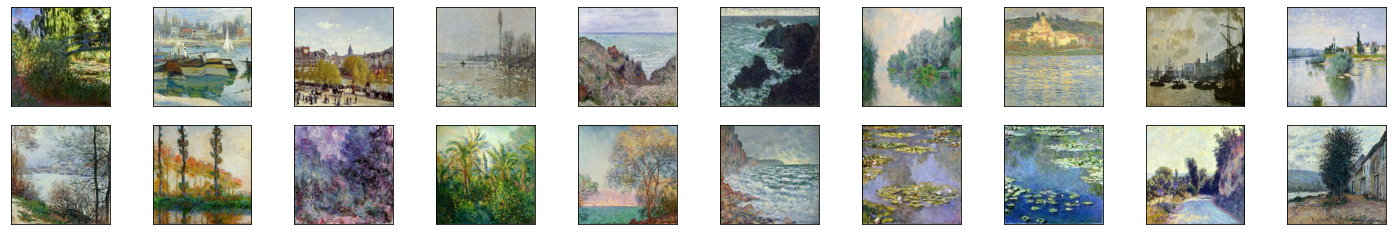

In [151]:
# obtain one batch of training images
dataiter = iter(loader_train)
images = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])